In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
rc('text', usetex=False)

import xarray as xr
import xgcm

import cartopy.crs as ccrs
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor=None, facecolor='papayawhip', linewidth=0.5)

import matplotlib.path as mpath




In [2]:
# set up a larger cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster





In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()

In [3]:
# either way, run this
client = Client(cluster)



In [4]:
print(client)

<Client: 'tcp://127.0.0.1:46583' processes=7 threads=28, memory=125.20 GiB>


## Input parameters

In [5]:
# these are the values used by MOM5

Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m


In [6]:
# Park and Durand front locations
ds_PD = xr.open_dataset('/g/data/jk72/ed7737/RoG plots/Park_Durand_ACC_fronts.nc')
# downloaded from https://www.seanoe.org/data/00486/59800/

In [7]:
import glob

In [8]:
import pandas as pd
import os

In [9]:
# orsi fronts
orsi_fronts_files = sorted(glob.glob('/g/data/jk72/ed7737/RoG plots/orsi_fronts/*.txt'))
orsi_fronts = {}

for file in orsi_fronts_files:
    front = os.path.splitext(os.path.basename(file))[0]
    front_data = np.loadtxt(file, comments='%')
    foo = {'lat':front_data[:,1], 'lon':front_data[:,0]}
    
    # deal with closed contours and discontinuities in SACCF

    # Compute the difference between successive lon values
    diffs = np.append(np.diff(foo['lat']), 0)
    # Find the differences that are greater than 2 degrees
    discont_indices = np.abs(diffs) > 5
    # Set those lon values to NaN
    foo['lon'][discont_indices] = np.nan

    orsi_fronts[front] = foo

orsi_front_names = ['sbdy', 'saccf', 'pf', 'saf', 'stf']
orsi_front_long_names = {'sbdy': 'Southern Boundary of the ACC',
                         'saccf': 'Southern ACC front',
                         'pf': 'Polar Front',
                         'saf':'Subantarctic Front',
                         'stf': 'Subtropical Front'}

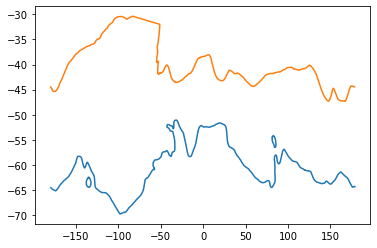

In [10]:
plt.plot(orsi_fronts['saccf']['lon'], orsi_fronts['saccf']['lat'])
plt.plot(orsi_fronts['stf']['lon'], orsi_fronts['stf']['lat'])

# 0.1° global


In [11]:
# session = cc.database.create_session()
session = cc.database.create_session()#db='/g/data/ik11/databases/cosima_master_2022-07-01.db')

# reference density value:
rho_0 = 1035.0
g = 9.81

# Restrict to Southern Ocean latitudes
lat_range = slice(-80,-35)

In [13]:
# expt = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle4'

start_time = '2009-01-01'
end_time = '2018-12-31'

time_slice = slice(start_time, end_time)

In [14]:
# laod variables

u = cc.querying.getvar(expt, 'u', session, start_time = start_time, end_time = end_time,)
u = u.sel(time=time_slice).sel(yu_ocean=lat_range)

# v = cc.querying.getvar(expt, 'v', session, start_time = start_time, end_time = end_time)
# v = v.sel(time=time_slice).sel(yu_ocean=lat_range)

# ssh = cc.querying.getvar(expt, 'sea_level', session, start_time = start_time, end_time = end_time, frequency ='1 monthly')
# ssh = ssh.sel(time=time_slice).sel(yt_ocean=lat_range)


tx_trans_int_z = cc.querying.getvar(expt, 'tx_trans_int_z', session, start_time = start_time, end_time = end_time)
tx_trans_int_z = tx_trans_int_z.sel(time=time_slice).sel(yt_ocean=lat_range)



In [15]:
# depth at temperature points
ht = cc.querying.getvar(expt, 'ht', session, n=1)

# coarsen ht to reduce wiggles and things

ht_coarse = ht.coarsen(xt_ocean=5).mean().coarsen(yt_ocean=5).mean()

In [16]:
xt_ocean = cc.querying.getvar(expt, 'xt_ocean', session, n=1)
yt_ocean = cc.querying.getvar(expt, 'yt_ocean', session, n=1)

st_ocean = cc.querying.getvar(expt,'st_ocean', session, n=-1)
st_edges_ocean= cc.querying.getvar(expt,'st_edges_ocean', session, n=-1)

dstF = xr.DataArray(st_edges_ocean.values[1:] - st_edges_ocean.values[:-1],
                   coords={'st_ocean':st_ocean},
                   dims={'st_ocean':st_ocean})

dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
dyt = cc.querying.getvar(expt, 'dyt', session, n=1)
dyu = cc.querying.getvar(expt, 'dyu', session, n=1)




In [17]:
ds = xr.Dataset({'u':u, 'xt_ocean':xt_ocean, 'yt_ocean':yt_ocean, 'st_edges_ocean':st_edges_ocean,
                'dxu':dxu, 'dyt':dyt, 'dyu':dyu, 'dstF':dstF})

# define grid metrics for automagic differentiation
metrics = {
    ('X',): ['dxu'],
    ('Y',): ['dyu', 'dyt'],
    ('Z',): ['dstF'],
            }


grid = xgcm.Grid(ds, coords={'X':{'center':'xt_ocean', 'right':'xu_ocean'},
                             'Y':{'center':'yt_ocean','right':'yu_ocean'},
                             'Z':{'center':'st_ocean', 'outer':'st_edges_ocean'}}, periodic = ['X'],
                metrics=metrics)




In [18]:
u_mean = u.mean(dim='time')
# ssh_mean = ssh.mean(dim='time')

In [19]:
tx_trans_int_z = tx_trans_int_z.mean(dim='time')

tx_trans_int_z

<xarray.DataArray 'tx_trans_int_z' (yt_ocean: 844, xu_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(844, 3600), dtype=float32, chunksize=(513, 720), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04

In [20]:

psi_b = tx_trans_int_z.cumsum('yt_ocean')/(1035*1e6)

In [21]:
psi_b = psi_b.load()

In [22]:
psi_b

<xarray.DataArray 'tx_trans_int_z' (yt_ocean: 844, xu_ocean: 3600)>
array([[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [172.15279, 172.0594 , 171.99002, ..., 172.39632, 172.32011,
        172.24422],
       [171.99043, 171.916  , 171.8697 , ..., 172.21582, 172.14091,
        172.06615],
       [171.82152, 171.75768, 171.71758, ..., 172.03195, 171.94987,
        171.88867]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04

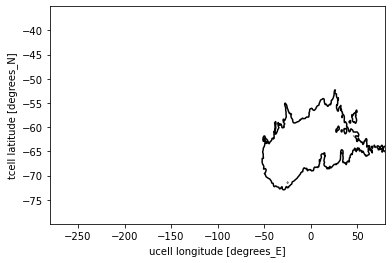

In [23]:
psi_b.where(psi_b['xu_ocean']>-60).plot.contour(colors='k', linewidth=5, levels=[-12], linestyles='solid')



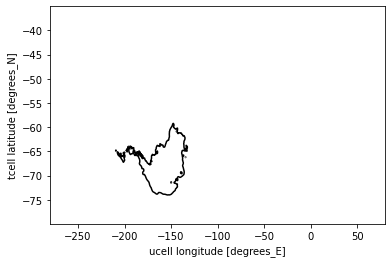

In [35]:
psi_b.where(psi_b['xu_ocean']<-110).where(psi_b['xu_ocean']>-210).plot.contour(colors='k', linewidth=5, levels=[-12], linestyles='solid')




In [24]:
u_surface_mean = u_mean.sel(st_ocean=20, method='nearest')

In [25]:
u_surface_mean = u_surface_mean.load()
u_surface_mean

<xarray.DataArray 'u' (yu_ocean: 844, xu_ocean: 3600)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00650635, 0.0070057 , 0.00767348, ..., 0.00578206, 0.00568439,
        0.00609309],
       [0.00547886, 0.00594421, 0.00654921, ..., 0.00460347, 0.00445056,
        0.00488118],
       [0.00501767, 0.00593298, 0.00694022, ..., 0.0044789 , 0.00417943,
        0.00436146]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -35.24 -35.16 -35.08
    st_ocean  float64 19.15

In [26]:
depth_contour_levels = np.array([3])*1e3
depth_contour_levels

array([3000.])

In [27]:
ssh_contour_levels = np.linspace(-2,1, num=7)
ssh_contour_levels

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

CPU times: user 4.34 s, sys: 449 ms, total: 4.79 s
Wall time: 4.33 s


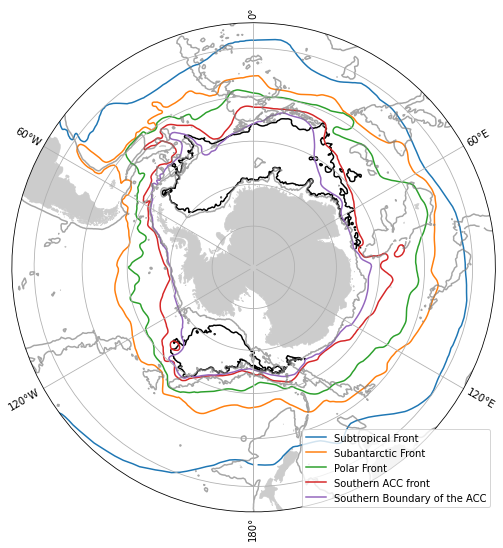

In [37]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
# ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)



# ssh_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=1, levels=ssh_contour_levels, linestyles='solid')

# Weddell Gyre
psi_b.where(psi_b['xu_ocean']>-60).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k',
                                                alpha=1, linewidth=5, levels=[-12], linestyles='solid')
# Ross gyre
psi_b.where(psi_b['xu_ocean']<-110).where(psi_b['xu_ocean']>-210).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k',
                                                                               linewidth=5, levels=[-12], linestyles='solid')



for front in orsi_front_names[::-1]:
    ax.plot(orsi_fronts[front]['lon'], orsi_fronts[front]['lat'],
            label=orsi_front_long_names[front],
            transform=ccrs.PlateCarree())

ax.legend()


ht_coarse.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='grey', alpha=0.7,
                       levels=depth_contour_levels, linestyles='solid')




CPU times: user 36min 52s, sys: 3min 50s, total: 40min 43s
Wall time: 35min 47s


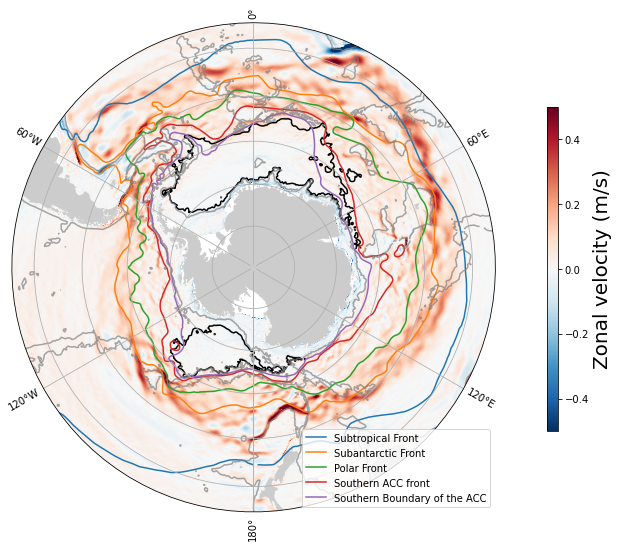

In [38]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
# ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)


p1 = u_surface_mean.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                                    vmin=-0.5, vmax=0.5, cmap='RdBu_r')
ax.set_title('')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Zonal velocity (m/s)', fontsize=20);

# ssh_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=1, levels=ssh_contour_levels, linestyles='solid')

# Weddell Gyre
psi_b.where(psi_b['xu_ocean']>-60).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k',
                                                alpha=1, linewidth=5, levels=[-12], linestyles='solid')
# Ross gyre
psi_b.where(psi_b['xu_ocean']<-110).where(psi_b['xu_ocean']>-210).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k',
                                                                               linewidth=5, levels=[-12], linestyles='solid')

# Orsi fronts
for front in orsi_front_names[::-1]:
    ax.plot(orsi_fronts[front]['lon'], orsi_fronts[front]['lat'],
            label=orsi_front_long_names[front],
            transform=ccrs.PlateCarree())

ax.legend()


ht_coarse.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='grey', alpha=0.7,
                       levels=depth_contour_levels, linestyles='solid')


fig.savefig('/g/data/jk72/ed7737/RoG plots/ACC_overview_with_gyres.png', dpi=200, bbox_inches='tight')